<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/21-2d_keypoint_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May  2 21:41:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Download video to VideoPose3D/inference/videos/ (& rename to output.mp4)

!wget -P videos/ https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
import os
os.rename('videos/golf_video_1.mp4', 'videos/output.mp4')

!pip install ffmpeg

--2023-05-02 21:41:47--  https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4 [following]
--2023-05-02 21:41:47--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20556022 (20M) [application/octet-stream]
Saving to: ‘videos/golf_video_1.mp4’

golf_video_1.mp4    100%[===================>]  19.60M  --.-KB/s    in 0.05s   

2023-05-02 21:41:48 (421 MB/s) - ‘videos/golf_video_1.mp4’ saved [

In [ ]:
import numpy as np
import subprocess as sp
def get_resolution(filename):
    
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))

In [ ]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A # Library for augmentations
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

import os
import cv2
import json
import time
import shutil
import random
import zipfile
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

repo_dir = "/content/"
data_path = repo_dir + "downloaded-data/"

In [ ]:
### Setup kaggle api ###
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v {data_path}

## Download and unzip  models ###
dataset_name = "2dgolfmodels"
model_name = "model_1_unfrozen_fpn_rotation.pth"
! kaggle datasets download jamesdavey/{dataset_name}
zip_path = data_path+f"datasets/jamesdavey/{dataset_name}/{dataset_name}.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

- path is now set to: /content/downloaded-data/
 99% 207M/209M [00:12<00:00, 20.9MB/s]
100% 209M/209M [00:12<00:00, 17.7MB/s]


In [ ]:
### Create and load model ###

device = 'cuda:0'
loaded_model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
loaded_model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
loaded_model.roi_heads.keypoint_predictor.kps_score_lowres = out
loaded_model.load_state_dict(torch.load('downloaded-data/'+model_name))
loaded_model = loaded_model.to(device)
loaded_model.eval()
list(loaded_model.backbone.fpn.parameters())[0][:5, :5, 0, 0]

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:02<00:00, 102MB/s]


tensor([[ 0.0147,  0.0075, -0.0089,  0.0045,  0.0334],
        [ 0.0065,  0.0109,  0.0309,  0.0022, -0.0179],
        [-0.0015,  0.0156, -0.0176,  0.0074,  0.0072],
        [ 0.0054,  0.0039,  0.0031,  0.0047,  0.0023],
        [-0.0004,  0.0019,  0.0303,  0.0166,  0.0116]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, frames):
        self.frames = frames
        self.img_transforms = transforms.ToTensor()
        
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        img = self.frames[idx]
        target = {}
        # target["boxes"] = torch.Tensor().unsqueeze(dim=0).type(torch.FloatTensor)
        # target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        # target["keypoints"] = torch.Tensor([grip + [1.], head + [1.]]).unsqueeze(dim=0).type(torch.FloatTensor)

        img = Image.fromarray(img)
        img = self.img_transforms(img)
        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# from PIL import Image, ImageOps
# for frame in frames[:5]:
#     display(ImageOps.contain(Image.fromarray(frame), (400, 400)))

In [ ]:
def generate_cords(frames):
    global keypoints
    global boxes
    print(f"Frames loaded: {len(frames)}")
    dataset = GolfDataset(frames)
    dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
    print(f"Dataset lengths: {len(dataset)}| Dataloader #batches: {len(dataloader)}, batches of size {batch_size}")

    coordinates = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            preds = loaded_model([img.to(device) for img in batch[0]])
            for labels in preds:
                try:
                    grip = [int(x) for x in labels['keypoints'][0, 0, :2]]
                    head = [int(x) for x in labels['keypoints'][0, 1, :2]]
                    box = [int(x) for x in labels['boxes'][0]]
                    keypoints_for_frame = [grip, head] # don't want to save box here
                    box_for_frame = box
                except Exception as e:
                    print(f"Skipping  frame | {e}")
                    keypoints_for_frame = keypoints[-1]
                    box_for_frame = boxes[-1]
                keypoints.append(keypoints_for_frame)
                boxes.append(box_for_frame)

In [ ]:
# Load video using ffmpeg
batch_size = 2
frames_at_once = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

keypoints = []
boxes = []

frame_idx = -1
frames = []
loaded_model.eval()
for f in read_video('videos/output.mp4'):
    frame_idx+=1
    if frame_idx < 192:
        keypoints.append([[0,0], [0,0]])
        boxes.append([0,0,0,0])
        continue
    frames.append(f)

    #split image into segments of size frames_at_once so it doesn't have to all be loaded at once
    if (len(frames) % frames_at_once == 0 and len(frames) != 0):
        generate_cords(frames)
        frames = []
        
if (len(frames) % frames_at_once != 0):
    generate_cords(frames)

np.save("keypoints_2d", keypoints)
np.save("boxes", boxes)

Frames loaded: 20
Dataset lengths: 20| Dataloader #batches: 10, batches of size 2
Frames loaded: 20
Dataset lengths: 20| Dataloader #batches: 10, batches of size 2
Frames loaded: 7
Dataset lengths: 7| Dataloader #batches: 4, batches of size 2


In [ ]:
loaded_2d_data = np.load("keypoints_2d.npy")
loaded_2d_data.shape, loaded_2d_data[200:202]

((239, 2, 2),
 array([[[ 772,  196],
         [1204,  164]],
 
        [[ 792,  190],
         [1243,  190]]]))

In [ ]:
loaded_boxes = np.load("boxes.npy")
loaded_2d_data.shape, loaded_2d_data[200:202]

((239, 2, 2),
 array([[[ 772,  196],
         [1204,  164]],
 
        [[ 792,  190],
         [1243,  190]]]))

In [ ]:
def label_img(img, keypoint, box):
    img = img.copy()
    grip, head = keypoint
    if box is not None: cv2.rectangle(img, box[:2], box[2:], (255,0,0), 3)
    cv2.circle(img, grip, 5, (255, 0, 255), -1)
    cv2.circle(img, head, 5, (255, 0, 255), -1)
    cv2.line(img, head, grip, (0, 255, 0), 2)
    return img

In [ ]:
import os
if not os.path.exists('labelled'):
   os.makedirs('labelled')

In [ ]:
# Load video using ffmpeg
frame_idx = -1
for f in read_video('videos/output.mp4'):
    frame_idx+=1
    if frame_idx < 192:
        continue
    labelled_frame = label_img(f, loaded_2d_data[frame_idx], loaded_boxes[frame_idx])
    labelled_frame = cv2.cvtColor(labelled_frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'labelled/image_{frame_idx}.jpg', labelled_frame)
    # display(ImageOps.contain(Image.fromarray(labelled_frame), (400, 400)))

    if frame_idx == 198:
        break

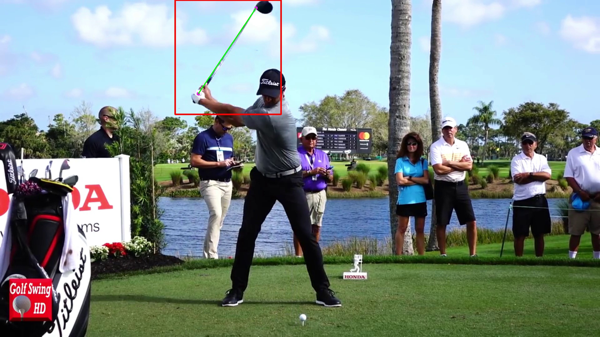

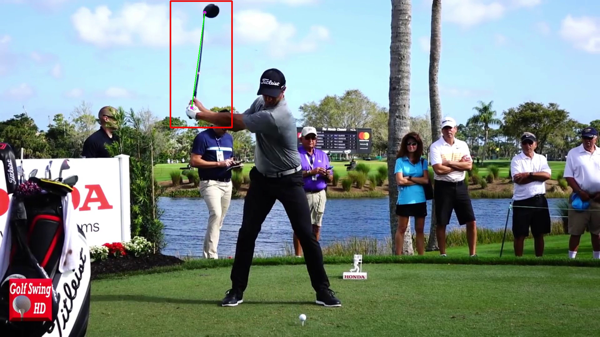

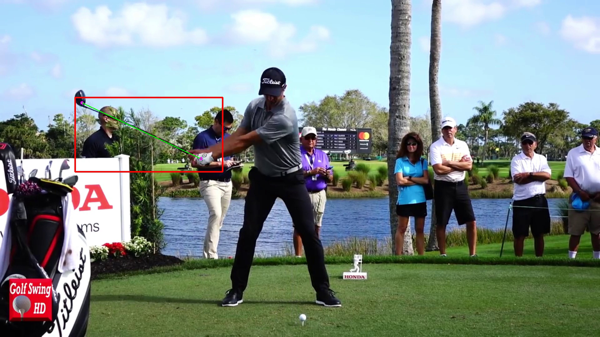

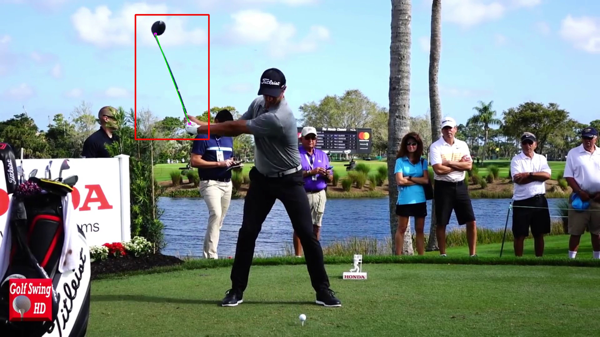

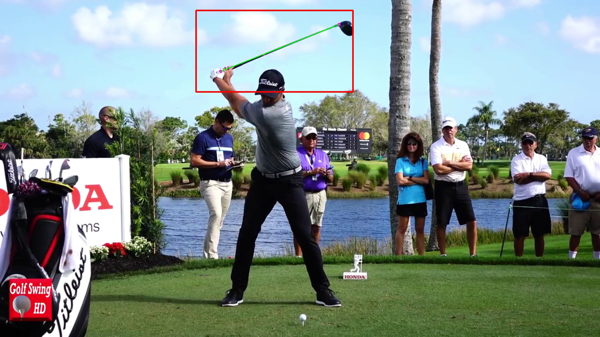

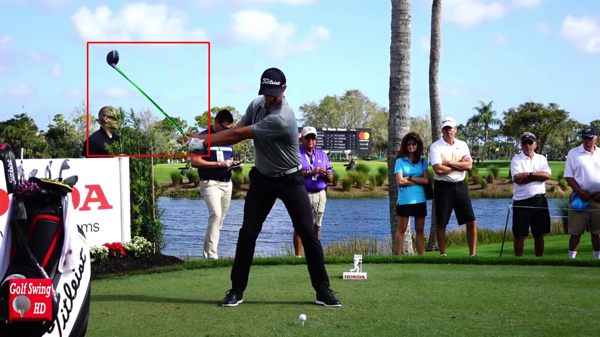

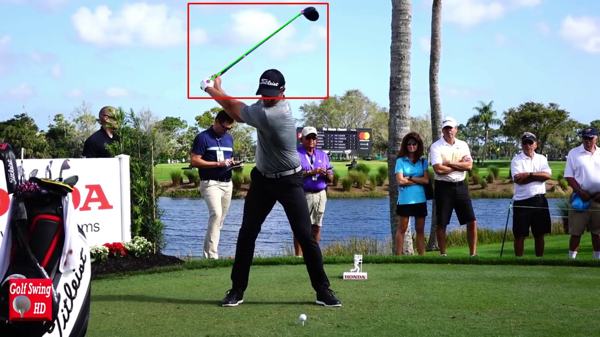

In [ ]:
for filename in os.listdir('labelled'):
    display(ImageOps.contain(Image.open('labelled/'+filename), (600, 600)))

In [ ]:
!cd labelled && ffmpeg -r 1 -i image_%01d.jpg -vcodec mpeg4 -y movie.mp4"

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
f'labelled/image_{frame_idx}'

'labelled/image_192'